# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).

## Review the data

Run the following cell to load the data and view the first few rows.

In [2]:
import joblib
import pandas as pd

# load the training dataset
data = pd.read_csv('../data/real_estate.csv')
data.head()

(414, 7)

The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## Train a Regression Model

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [02 - Real Estate Regression Solution.ipynb](02%20-%20Real%20Estate%20Regression%20Solution.ipynb).

### Preperations

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from scipy.stats import pearsonr

from shared_code.utils import *

### Explore the data

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          334 non-null    float64
 1   house_age                 334 non-null    float64
 2   transit_distance          334 non-null    float64
 3   local_convenience_stores  334 non-null    int64  
 4   latitude                  334 non-null    float64
 5   longitude                 334 non-null    float64
 6   price_per_unit            334 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 20.9 KB


(334, 7)

We can see from the data information. There is no null values in every feature. All the features are float or int type.

price_per_unit 
Minimum:7.60
Mean:37.98
Median:38.45
Mode:24.70
Maximum:117.50



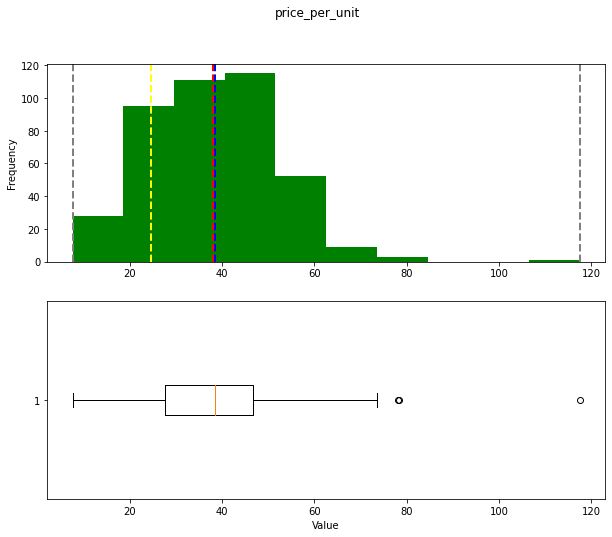

price_per_unit 
Minimum:7.60
Mean:37.34
Median:38.25
Mode:24.70
Maximum:69.70



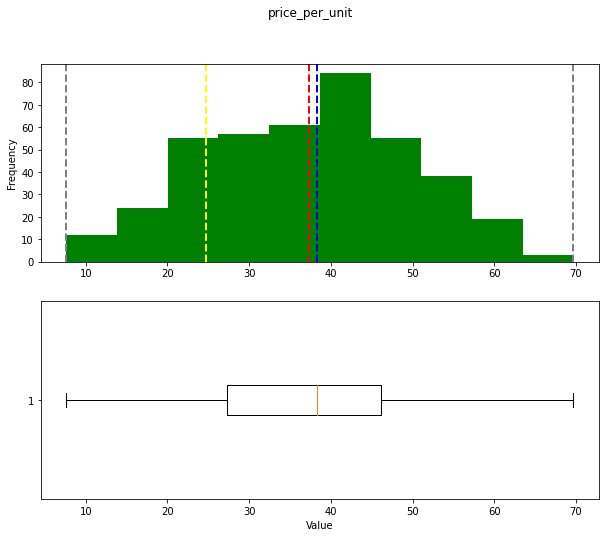

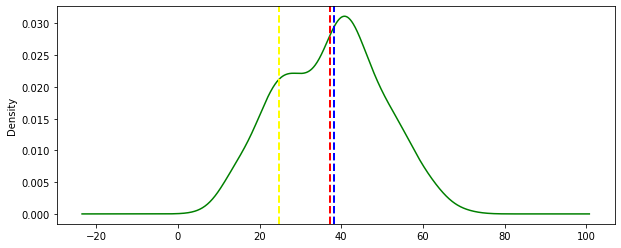

house_age 
Minimum:0.00
Mean:17.77
Median:16.15
Mode:0.00
Maximum:43.80



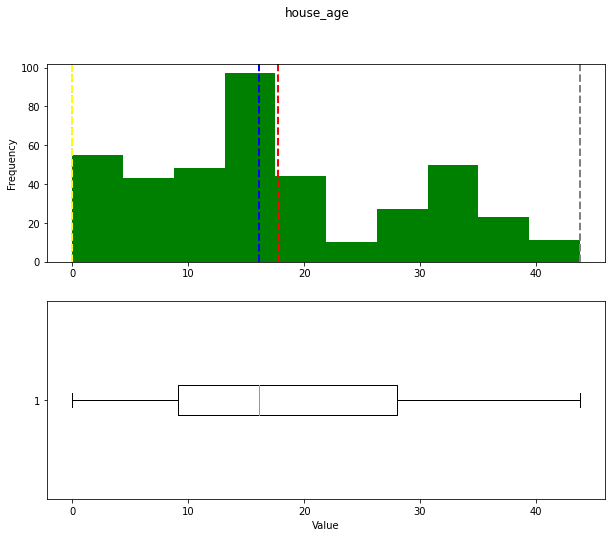

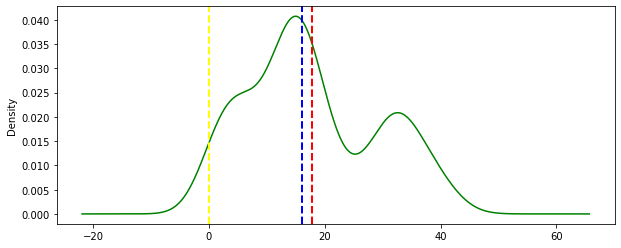

Correlation: -0.2201307953680457


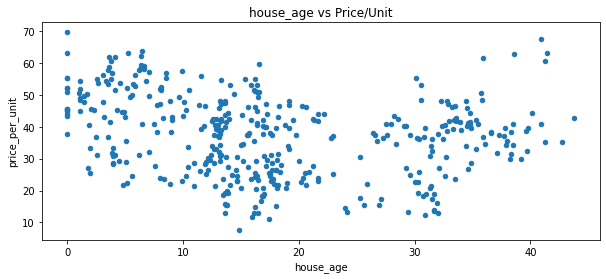

transit_distance 
Minimum:23.38
Mean:1095.81
Median:492.94
Mode:289.32
Maximum:6488.02



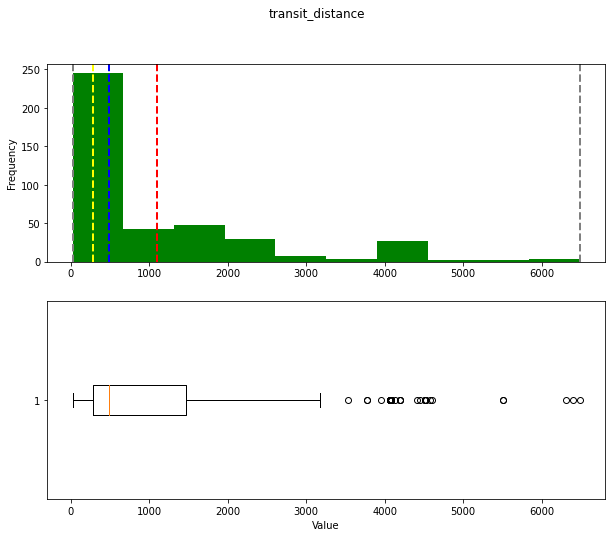

transit_distance 
Minimum:23.38
Mean:738.28
Median:463.96
Mode:289.32
Maximum:2707.39



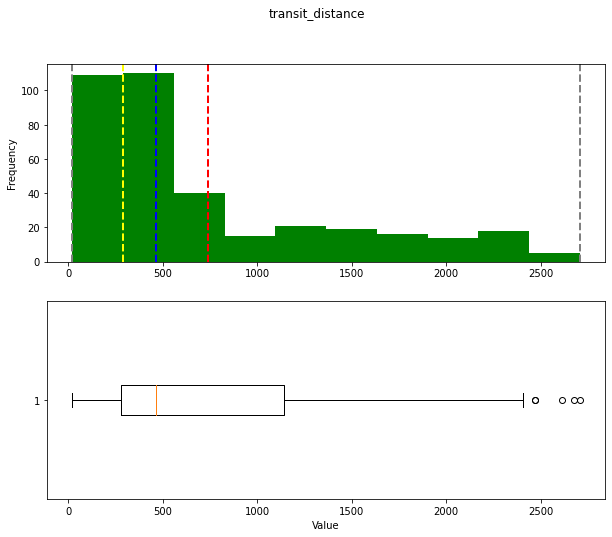

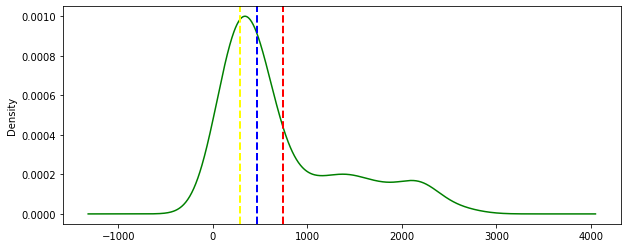

Correlation: -0.6926056757309371


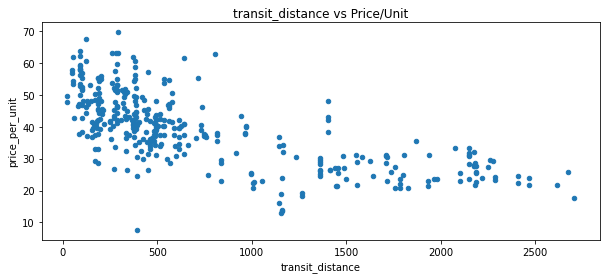

local_convenience_stores 
Minimum:0.00
Mean:4.49
Median:5.00
Mode:5.00
Maximum:10.00



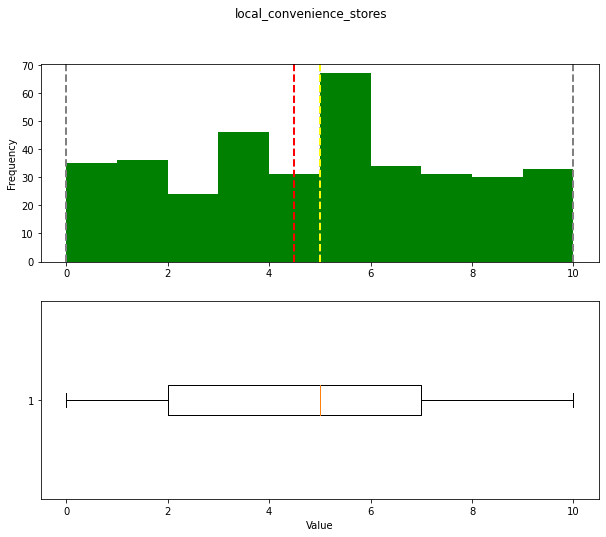

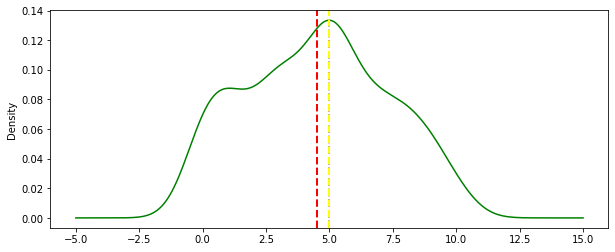

Correlation: 0.5297100895358571


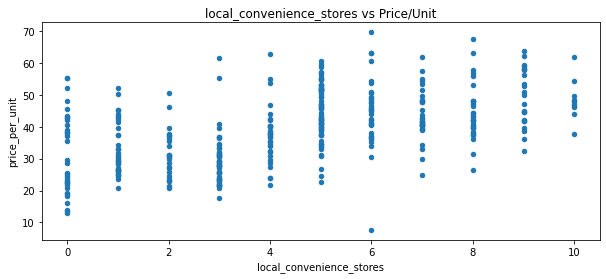

latitude 
Minimum:24.95
Mean:24.97
Median:24.97
Mode:24.97
Maximum:24.99



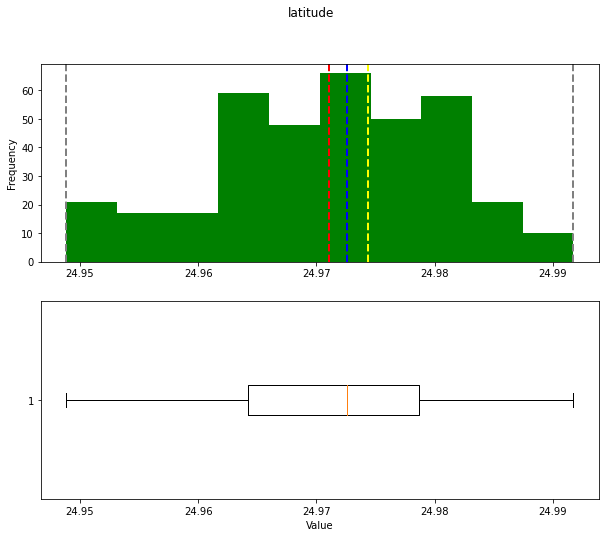

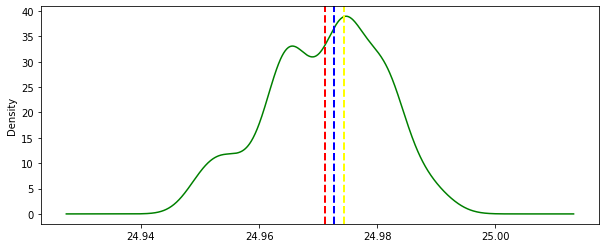

Correlation: 0.4592604249097903


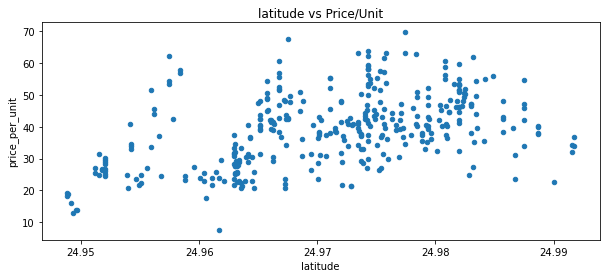

longitude 
Minimum:121.51
Mean:121.54
Median:121.54
Mode:121.54
Maximum:121.56



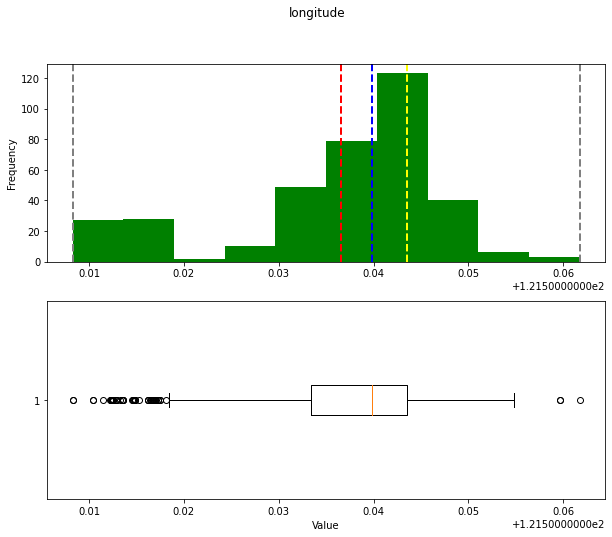

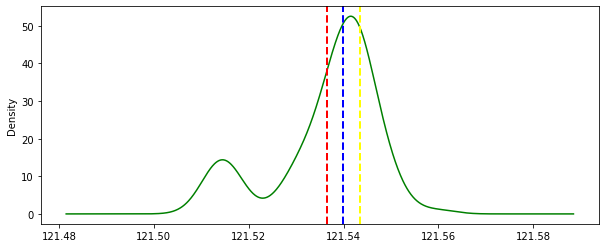

Correlation: 0.39152202010264864


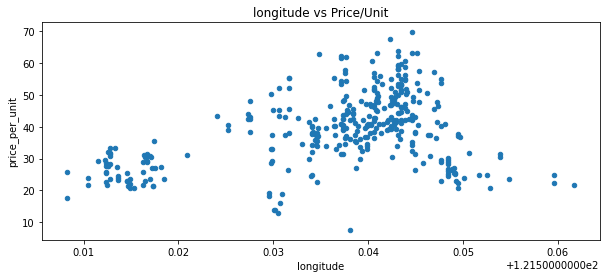

In [119]:
# Explore the data

# Show the distribution of labels
show_distribution(data['price_per_unit'])

# Remove outliers from labels
data = data[data['price_per_unit'] < 70]

show_distribution(data['price_per_unit'])
show_density(data['price_per_unit'])

# Explore features
numeric_features = ['house_age', 'transit_distance', 'local_convenience_stores', 'latitude', 'longitude']
for feature in numeric_features:

    # Show the distribution of original data
    show_distribution(data[feature])

    # Trim the outliers of transit_distance
    if feature == 'transit_distance':
        data = trim_outliers_maximum(data, feature, 0.9)

        # Show the distributions without outliers
        show_distribution(data[feature])

    # Show the density function graphic
    show_density(data[feature])

    # Show the scatter plot between each feature and label
    data.plot.scatter(title=feature + ' vs Price/Unit', x=feature, y='price_per_unit', figsize=(10, 4))

    # Get the correlations between the features and labels
    correlations, _ = pearsonr(data[feature], data['price_per_unit'])
    print('Correlation: {}'.format(correlations))

    plt.show()

From the visualizations of each feature, transaction date shows no definitely affection on price of every unit. The house
age has no obvious affection on price of house. But it indicates that house between 0 year and 20 years will have a better salse.
However, the 30 years old houses have a not bad sales as well. Regardless of some very far distances, the most of the distance to the
nearest light railway station are less than 600 meters. The most people choose the distance between 300 meters and 400 meters.
The amount of local convenience stores has no obvious effects on the price of the unit.

### Linear Regression

MSE: 57.25944027676626
RMSE: 7.566996780544199
R2:0.5828302383804642
Wall time: 19.6 ms


<function matplotlib.pyplot.show(close=None, block=None)>

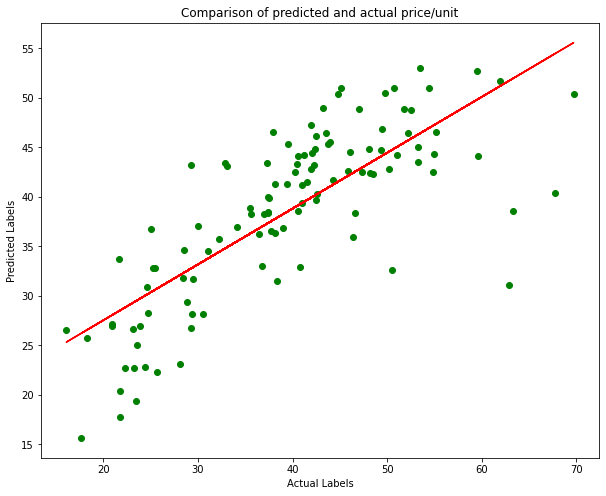

In [113]:
%%time

# Split the training and testing dataset
X = data.iloc[:, :-1]
y = data['price_per_unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Create preprocessing and training model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model with training dataset
model = pipeline.fit(X_train, y_train)

# Get predictions with testing dataset
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('MSE: {}\nRMSE: {}\nR2:{}'.format(mse, rmse, r2))

# Plot the predicted labels and actual labels
fig = plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions, color='green')

plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Comparison of predicted and actual price/unit')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red')

# Show the graphic
plt.show

The Linear Regression model return with the RMSE of 7.56, which is larger than the required 7. We will try more models.

### Decision Trees

Desision Tree model without GridSearchCV.

The best parameter combination:{'regressor__max_depth': 10, 'regressor__max_leaf_nodes': 50, 'regressor__min_samples_leaf': 10, 'regressor__random_state': 7}

MSE: 49.915389515969586
RMSE: 7.065082413954531
R2:0.6363361037957513


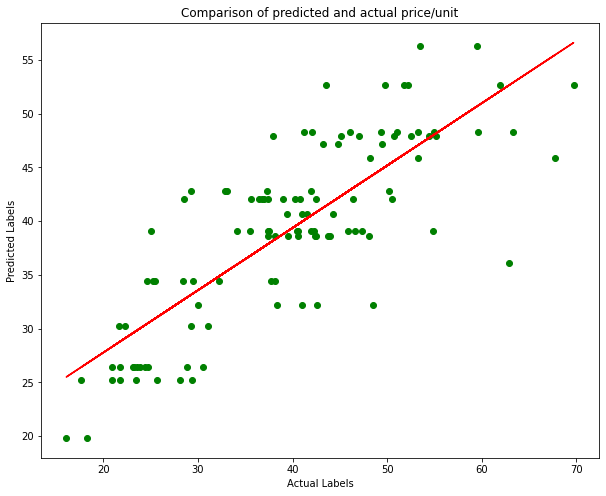

Wall time: 1.12 s


In [114]:
%%time

# Create preprocessing and training model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

# Identify the hyperparameters
params = {
    'regressor__max_depth': [2, 5, 10],
    'regressor__max_leaf_nodes': [10, 50, 100],
    'regressor__min_samples_leaf': [5, 10, 20],
    'regressor__random_state': [7]
}

# Fit the training dataset to find the best hyperparameters to get the optimal R2
score = make_scorer(r2_score)
grid_search = GridSearchCV(pipeline, params, scoring=score, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Fit the model with training dataset
print('The best parameter combination:{}\n'.format(grid_search.best_params_))

# Get predictions with testing dataset
predictions = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('MSE: {}\nRMSE: {}\nR2:{}'.format(mse, rmse, r2))

# Plot the predicted labels and actual labels
fig = plt.figure(figsize=(10, 8))

plt.scatter(y_test, predictions, color='green')

plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Comparison of predicted and actual price/unit')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')

# Show the graphic
plt.show()

The Decision Tree model return with the RMSE of 7.06, which is larger than the required 7. We will try more models.

### Gradient Boosting Regression

Gradient Boosting Regression model without GridSearchCV.

The best parameter combination:{'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 10, 'random_state': 7}

MSE: 47.71498613308185
RMSE: 6.907603501438241
R2:0.6523673774210117


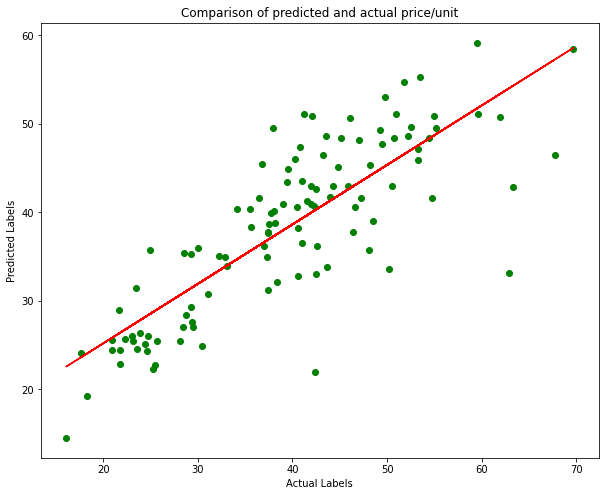

Wall time: 2.43 s


In [122]:
%%time

# Define preprocessing for numeric features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Split the training and testing dataset
X = data.iloc[:, 1:-1]
y = data['price_per_unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

# Identify the hyperparameters
params = {
    'max_depth': [2, 5, 10],
    'max_leaf_nodes': [5, 10, 50],
    'min_samples_leaf': [5, 10, 20],
    'random_state': [7]
}

# Fit the training dataset to find the best hyperparameters to get the optimal R2
score = make_scorer(r2_score)
grid_search = GridSearchCV(GradientBoostingRegressor(), params, scoring=score, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Fit the model with training dataset
print('The best parameter combination:{}\n'.format(grid_search.best_params_))

# Get predictions with testing dataset
predictions = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('MSE: {}\nRMSE: {}\nR2:{}'.format(mse, rmse, r2))

# Plot the predicted labels and actual labels
fig = plt.figure(figsize=(10, 8))

plt.scatter(y_test, predictions, color='green')

plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Comparison of predicted and actual price/unit')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')

# Show the graphic
plt.show()

The Gradient Boosting Regression has the RMSE 6.9.

### Random Forest Regression

The best parameter combination:{'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'random_state': 7}

MSE: 44.33319347730749
RMSE: 6.658317616133034
R2:0.6770057886460779


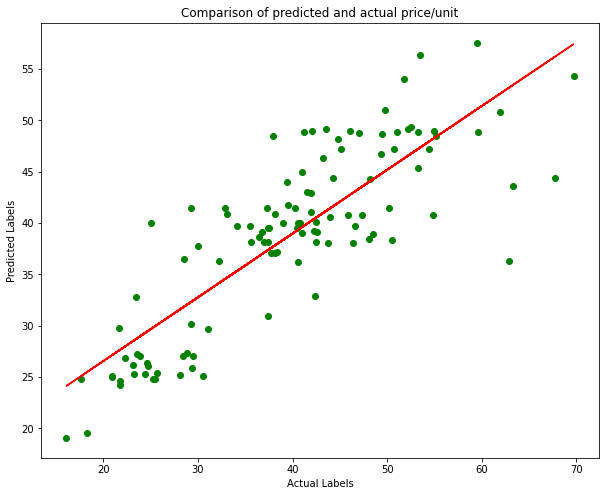

Wall time: 7.22 s


In [123]:
%%time

# Identify the hyperparameters
params = {
    'max_depth': [2, 5, 10],
    'max_leaf_nodes': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
    'random_state': [7]
}

# Fit the training dataset to find the best hyperparameters to get the optimal R2
score = make_scorer(r2_score)
grid_search = GridSearchCV(RandomForestRegressor(), params, scoring=score, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Fit the model with training dataset
print('The best parameter combination:{}\n'.format(grid_search.best_params_))

# Get predictions with testing dataset
predictions = grid_search.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print('MSE: {}\nRMSE: {}\nR2:{}'.format(mse, rmse, r2))

# Plot the predicted labels and actual labels
fig = plt.figure(figsize=(10, 8))

plt.scatter(y_test, predictions, color='green')

plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Comparison of predicted and actual price/unit')

z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')

# Show the graphic
plt.show()

The Gradient Boosting Regression has the RMSE 6.66. But the time it used is 7.27s.

# TODO: TRY EXTRACT MONTH, DAY, WEEK OF DATE

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [125]:
import joblib

# Save the model as a pickle file
filename = './real_estate_model.pkl'
joblib.dump(grid_search, filename)

# Load the model from the file
model = joblib.load(filename)


# Predict array
X_new = np.array([[16.2,289.3248,5,24.98203,121.54348],
                  [13.6,4082.015,0,24.94155,121.5038]])

predictions_new = model.predict(X_new)
print(predictions_new)

[32.90203262 32.90203262]


c:\users\xiao_meng\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
